<a href="https://colab.research.google.com/github/kumgleb/McKinsey_prohack_2020/blob/master/Data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports:

In [ ]:
! pip install pygam

     |████████████████████████████████| 1.8MB 2.8MB/s 


In [ ]:
import pandas as pd
import numpy as np
import missingno as msno 

import matplotlib.pyplot as plt
import seaborn as sns

from pygam import LinearGAM

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA 
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.simplefilter('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
np.random.seed(42)

In [ ]:
train_subset = pd.read_csv('/Data/train_subset.csv')
test_subset = pd.read_csv('/Data/test_subset.csv')

# Filling missing values:

Let's see missing values of features subset:

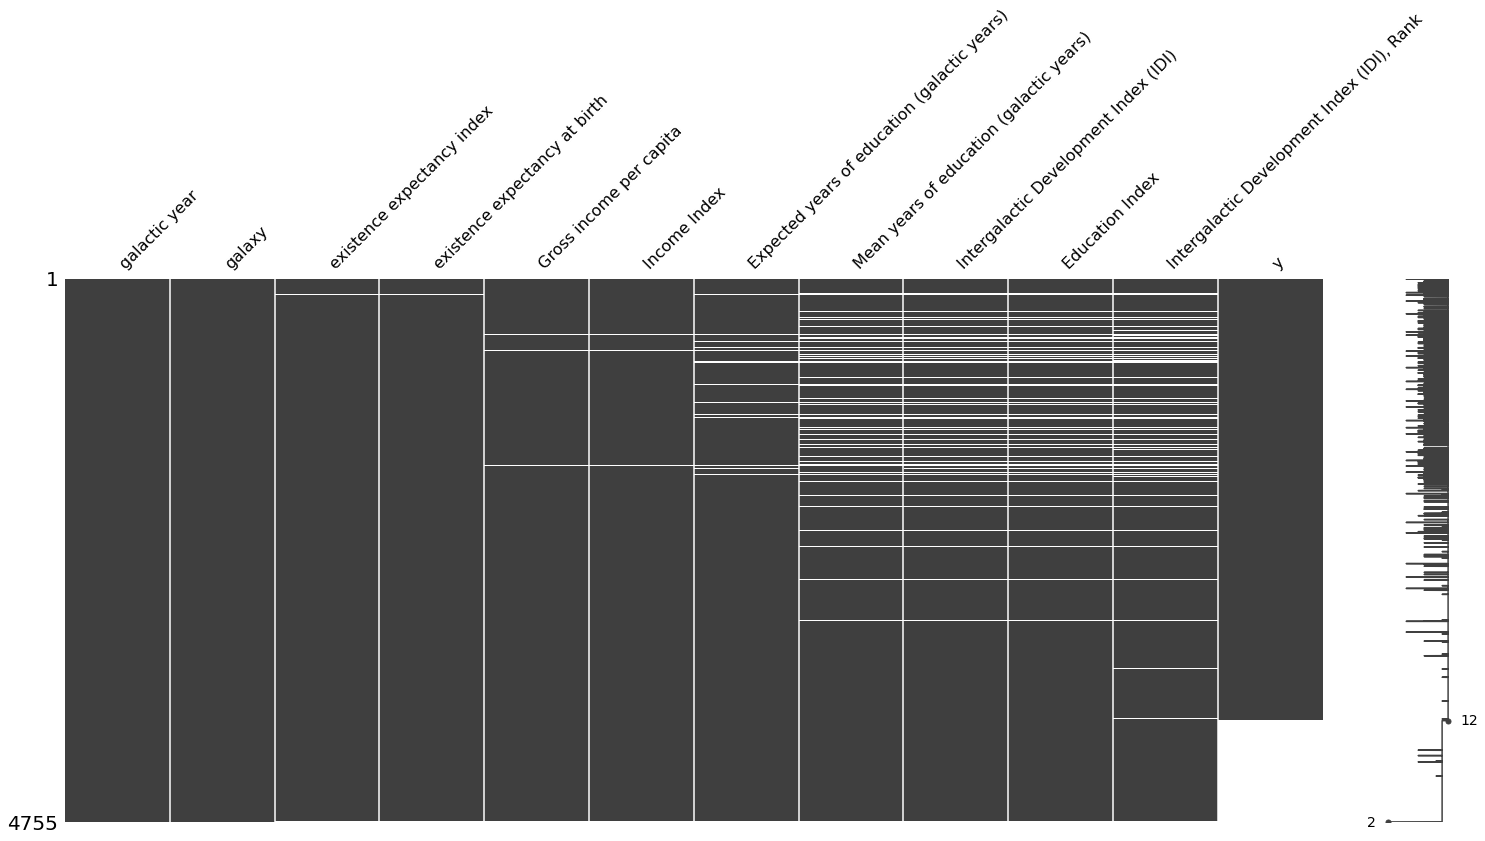

In [ ]:
train_and_test = pd.concat([train_subset, test_subset])

msno.matrix(train_and_test)

In [ ]:
def check_missing_values(train_df, test_df):

  df = pd.concat([train_df, test_df])
  df.drop('y', axis=1, inplace=True)
  nan_ratio = df.isna().sum().sum() / df.shape[0] / df.shape[1] * 100

  print(f'There is {nan_ratio:.1f}% of missing values in train and test subsets. \n')

  for feature in df.columns:
    nan_ratio = df[feature].isna().sum() / df.shape[0] * 100
    if nan_ratio > 0:
      max_nans = 0
      max_nans_glxy = 0
      for glxy in df.galaxy.unique():
        glxy_ftr_nans = (df[df['galaxy'] == glxy][feature].isna().sum() /
                        df[df['galaxy'] == glxy].shape[0] * 100)
        if glxy_ftr_nans > max_nans:
          max_nans_glxy = glxy
          max_nans = glxy_ftr_nans

    print(f'There is {nan_ratio:.1f}% nans in the column {feature}')
    if nan_ratio > 0:
      print(f'  max nans in galaxy {max_nans_glxy}, {max_nans:.2f}%. \n')

In [ ]:
check_missing_values(train_subset, test_subset)

There is 3.5% of missing values in train and test subsets. 

There is 0.0% nans in the column galactic year
There is 0.0% nans in the column galaxy
There is 0.1% nans in the column existence expectancy index
  max nans in galaxy NGC 5253, 100.00%. 

There is 0.1% nans in the column existence expectancy at birth
  max nans in galaxy NGC 5253, 100.00%. 

There is 0.7% nans in the column Gross income per capita
  max nans in galaxy UGC 8651 (DDO 181), 69.23%. 

There is 0.7% nans in the column Income Index
  max nans in galaxy UGC 8651 (DDO 181), 69.23%. 

There is 2.9% nans in the column Expected years of education (galactic years)
  max nans in galaxy NGC 5253, 100.00%. 

There is 7.8% nans in the column Mean years of education (galactic years)
  max nans in galaxy NGC 5253, 100.00%. 

There is 8.4% nans in the column Intergalactic Development Index (IDI)
  max nans in galaxy NGC 5253, 100.00%. 

There is 8.4% nans in the column Education Index
  max nans in galaxy NGC 5253, 100.00%. 



Here I decided to use following strategy to fill in the missing values:
1. Find KNN galaxies for every galaxy using a subset of data without missing values based on the all features and target.
2. Substitute the missing values with mean values of KNN galaxies for corresponding years.
3. Interpolate the rest of missing values if there is data for at least 5 years.
4. Substitute the rest of the missing values with global mean. 

In order to find KNN for every galaxy, I preprocess features with MinMax scaler and search for neighbours which bear cosine similarity.

In [ ]:
train_subset_no_nan = train_subset.dropna(axis=0)

static_clmns = train_subset_no_nan.columns[:2]
clmns_to_scale = train_subset_no_nan.columns[2:]

static_part = train_subset_no_nan[static_clmns]
part_to_scale = train_subset_no_nan[clmns_to_scale]

In [ ]:
sclr = MinMaxScaler()
scaled_data = sclr.fit_transform(part_to_scale)
scaled_data = pd.DataFrame(scaled_data, columns=part_to_scale.columns)

df_scaled = np.concatenate([static_part, scaled_data], axis=1)
df_scaled = pd.DataFrame(df_scaled, columns=train_subset_no_nan.columns)

In [ ]:
train_test_spit_trsh_year = test_subset['galactic year'].min()
print(f'Train treshold year: {train_test_spit_trsh_year}')

Train treshold year: 1007012


In [ ]:
def find_knn_pool(df, max_knn=10, trshld_year=1007012):

  '''
  Function calculates similarity between galaxies for every year from union of the years.

  Returns dict with galaxies as a key and `max_knn` pairs of 
  neighbouring galaxies and cosine distances for them for every year from union.
  '''

  clmns_for_knn = df.columns[2:]
  knn_pools = {glxy: [] for glxy in df['galaxy'].unique()}
  df = df[df['galactic year'] < trshld_year]

  for galaxy in df['galaxy'].unique():
    rest_galaxys = df.query('galaxy not in @galaxy')
    glxy_years = df[df['galaxy'] == galaxy]['galactic year']
    for year in glxy_years:

      current_gal_year = df[(df['galaxy'] == galaxy) & (df['galactic year'] == year)]
      assert current_gal_year.shape[0] == 1
      rest_galaxys_subset = rest_galaxys[rest_galaxys['galactic year'] == year]
      frame_for_knn = pd.concat([current_gal_year, rest_galaxys_subset], axis=0)

      NN = NearestNeighbors(max_knn, metric='cosine')
      distance_knn = NN.fit(frame_for_knn[clmns_for_knn])
      labels = distance_knn.kneighbors()[1]
      distances = distance_knn.kneighbors()[0]
      
      for i, dist in zip(labels[0], distances[0]):
        knn_glxy_name = frame_for_knn.iloc[i]['galaxy']
        knn_pools[galaxy].append((knn_glxy_name, dist))

  return knn_pools

In [ ]:
def reduce_pools(knn_pools, max_knn=10, only_names=True):

  '''
  Function averages the distance between galaxies.

  Returns dict with galaxies and `max_knn` neighbours with cosine distance averaged by years.
  '''

  # reducing part - averaging of galaxys similarity over the years
  reduced_dict = {key: [] for key in knn_pools.keys()}
  for key in knn_pools.keys():
    tmp_dict = dict()
    for item in knn_pools[key]:
      if item[0] not in tmp_dict:
        tmp_dict[item[0]] = [item[1]]
      else:
        tmp_dict[item[0]].append(item[1])
    
    for key_2 in tmp_dict.keys():
      reduced_dict[key].append((key_2, np.array(tmp_dict[key_2]).mean()))

  # sorting part - returning only `max_knn` most similar galasys in average
  final_result = {key: [] for key in reduced_dict.keys()}
  for key in reduced_dict.keys():
    items = reduced_dict[key]
    items.sort(key=lambda x: x[1], reverse=False)
    final_result[key] = items[:max_knn]
  
  if only_names:
    for key in final_result.keys():
      final_result[key] = [name[0] for name in final_result[key]]

  return final_result

In [ ]:
# find KNN for every year
knn_pools = find_knn_pool(df_scaled, max_knn=7)

# average similarity of KNN's by years
red_pools = reduce_pools(knn_pools, max_knn=7, only_names=True) 

In [ ]:
def fill_nan_with_knn(train_df, test_df, knn_data):

  '''
  Function fills in missing values with mean values from KNN.
  '''

  df = pd.concat([train_df, test_df]).reset_index()
  N = train_df.shape[0]

  for clmn in df.columns[:-1]:
    if df[clmn].isna().sum() != 0:

      idx_to_fill = df[clmn].isna().index
      for j in idx_to_fill:
        glxy, year = df.loc[j, 'galaxy'], df.loc[j, 'galactic year']

        if glxy in knn_data.keys():
          knn = knn_data[glxy]
          knn_feature_value = df.query('galaxy in @knn')[df['galactic year'] == year][clmn].mean() 
          if knn_feature_value and knn_feature_value is not np.nan:
            df.loc[j, clmn] = knn_feature_value

  df.drop('index', axis=1, inplace=True)
  train = df.loc[:N-1]
  test = df.loc[N:]

  return train, test

In [ ]:
# fill missing values with mean values of KNN
train_subset_filled, test_subset_filled = fill_nan_with_knn(train_subset, test_subset, red_pools)

In [ ]:
check_missing_values(train_subset_filled, test_subset_filled)

There is 0.5% of missing values in train and test subsets. 

There is 0.0% nans in the column galactic year
There is 0.0% nans in the column galaxy
There is 0.0% nans in the column existence expectancy index
  max nans in galaxy NGC 5253, 100.00%. 

There is 0.0% nans in the column existence expectancy at birth
  max nans in galaxy NGC 5253, 100.00%. 

There is 0.4% nans in the column Gross income per capita
  max nans in galaxy UGC 8651 (DDO 181), 69.23%. 

There is 0.4% nans in the column Income Index
  max nans in galaxy UGC 8651 (DDO 181), 69.23%. 

There is 0.7% nans in the column Expected years of education (galactic years)
  max nans in galaxy NGC 5253, 100.00%. 

There is 0.8% nans in the column Mean years of education (galactic years)
  max nans in galaxy NGC 5253, 100.00%. 

There is 0.9% nans in the column Intergalactic Development Index (IDI)
  max nans in galaxy NGC 5253, 100.00%. 

There is 0.9% nans in the column Education Index
  max nans in galaxy NGC 5253, 100.00%. 



Percent of missing values was reduced from 3.5% -> 0.5%.

Now one can interopalte missing values for galaxies:

In [ ]:
def interpolate_nans_with_LinearGAM(train_df, test_df):

  '''
  Function fills in the missing values using trained model with respect to years for every galaxy.
  Uses LinearGAM model if there are more than 4 years data avaliable.
  Values are filled for train and test at the same time, then train and test 
  are returned separately.
  '''

  df = pd.concat([train_df, test_df]).reset_index()
  N = train_df.shape[0]

  for clmn in df.columns[:-1]:
    if df[clmn].isna().sum() != 0:

      # galaxys with missing values
      galaxy_to_fill = set()
      for idx in df[df[clmn].isna()].index:
        galaxy_to_fill.add(df.loc[idx].galaxy)

      for galaxy in galaxy_to_fill:
        use_model = False
        train_df = df[df['galaxy'] == galaxy][['galactic year', clmn]].dropna(axis=0)
        if train_df.shape[0] >= 5:
          use_model = True
          x = train_df['galactic year'].values.reshape(-1, 1)
          y = train_df[clmn].values
          model_gam = LinearGAM(n_splines=5, verbose=False).gridsearch(x, y, progress=False)

        idx_to_fill = df[df['galaxy'] == galaxy][clmn].isna().index
        for j in idx_to_fill:
          if use_model:
            x_prd = pd.Series(df.loc[j, 'galactic year']).values.reshape(-1, 1)
            df.loc[j, clmn] = model_gam.predict(x_prd)

  df.drop('index', axis=1, inplace=True)
  train = df.loc[:N-1]
  test = df.loc[N:]

  return train, test

In [ ]:
train_subset_filled, test_subset_filled = interpolate_nans_with_LinearGAM(train_subset_filled, test_subset_filled)

In [ ]:
check_missing_values(train_subset_filled, test_subset_filled)

There is 0.1% of missing values in train and test subsets. 

There is 0.0% nans in the column galactic year
There is 0.0% nans in the column galaxy
There is 0.0% nans in the column existence expectancy index
  max nans in galaxy NGC 5253, 100.00%. 

There is 0.0% nans in the column existence expectancy at birth
  max nans in galaxy NGC 5253, 100.00%. 

There is 0.0% nans in the column Gross income per capita
There is 0.0% nans in the column Income Index
There is 0.0% nans in the column Expected years of education (galactic years)
  max nans in galaxy NGC 5253, 100.00%. 

There is 0.0% nans in the column Mean years of education (galactic years)
  max nans in galaxy NGC 5253, 100.00%. 

There is 0.0% nans in the column Intergalactic Development Index (IDI)
  max nans in galaxy NGC 5253, 100.00%. 

There is 0.0% nans in the column Education Index
  max nans in galaxy NGC 5253, 100.00%. 

There is 0.6% nans in the column Intergalactic Development Index (IDI), Rank
  max nans in galaxy NGC 

Percent of missing values was reduced from 0.5% -> 0.1%.

And finally we fill the rest of the missing values with global mean:

In [ ]:
def fill_with_global_mean(train_df, test_df):

  df = pd.concat([train_df, test_df]).reset_index()
  N = train_df.shape[0]
  
  for clmn in df.columns[:-1]:
    if df[clmn].isna().sum() != 0:
      df[clmn].fillna(df[clmn].mean(), inplace=True)

  df.drop('index', axis=1, inplace=True)
  train = df.loc[:N-1]
  test = df.loc[N:]

  return train, test

In [ ]:
train_subset_filled, test_subset_filled = fill_with_global_mean(train_subset_filled, test_subset_filled)

In [ ]:
check_missing_values(train_subset_filled, test_subset_filled)

There is 0.0% of missing values in train and test subsets. 

There is 0.0% nans in the column galactic year
There is 0.0% nans in the column galaxy
There is 0.0% nans in the column existence expectancy index
There is 0.0% nans in the column existence expectancy at birth
There is 0.0% nans in the column Gross income per capita
There is 0.0% nans in the column Income Index
There is 0.0% nans in the column Expected years of education (galactic years)
There is 0.0% nans in the column Mean years of education (galactic years)
There is 0.0% nans in the column Intergalactic Development Index (IDI)
There is 0.0% nans in the column Education Index
There is 0.0% nans in the column Intergalactic Development Index (IDI), Rank


Now lets scheck polssible descrepancy and outliers in filled dataset:

In [ ]:
def find_discrepancy(train_df, test_df, quantiles=[0.05, 0.95], treshold=3):

  '''
  Function searches for basic discrepancy in data such as:
    - negative values or values more then 100 in features with %
    - negative age
    - outliers as values > `quantiles` * `treshold`
  Returns a list of suspicious features.
  '''

  outliers_list = set()

  df = pd.concat([train_df, test_df]).reset_index()

  for clmn in df.columns:
    if df[clmn].dtype == 'float64':
      lb = df[clmn].quantile(quantiles[0])
      rb = df[clmn].quantile(quantiles[1])

      # validation of % data
      if '%' in clmn:
        if df[clmn].min() < 0:
          print(f'Negative % ratio in column {clmn}')
          outliers_list.add(clmn)
          print('-----------\n')
        if df[clmn].max() > 100:
          print(f'More then 100% in column {clmn}')
          outliers_list.add(clmn)
          print('-----------\n')

      if 'age' in clmn or 'years' in clmn:
        if df[clmn].min() < 0:
          print(f'Invalid age or years data in column {clmn}')
          print('------------\n')
          outliers_list.add(clmn)

      if df[df[clmn] < lb/treshold].shape[0] != 0:
        print(f'Column {clmn} with {df[df[clmn] < lb/treshold].shape[0]} outliers, values lower then {lb/treshold:.2f} were founded.')
        print(f'Mean value: {df[clmn].mean():.2f}')
        print(f'Left quantile : {lb:.2f}')
        print(f'Mean of outliers : {df[df[clmn] < lb/treshold][clmn].mean():.2f}')
        print(f'Min outlier : {df[df[clmn] < lb/treshold][clmn].min():.2f}')
        print('--------------\n')
        outliers_list.add(clmn)

      if df[df[clmn] > rb*treshold].shape[0] != 0:
        print(f'Column {clmn} with {df[df[clmn] > rb*treshold].shape[0]} outliers, values higher then {rb*treshold:.2f} were founded.')
        print(f'Mean value: {df[clmn].mean():.2f}')
        print(f'Right quantile : {rb:.2f}')
        print(f'Mean of outliers : {df[df[clmn] > rb*treshold][clmn].mean():.2f}')
        print(f'Max outlier : {df[df[clmn] > rb*treshold][clmn].max():.2f}')
        print('--------------\n')
        outliers_list.add(clmn)

  return outliers_list

In [ ]:
outliers_list = find_discrepancy(train_subset_filled, test_subset_filled)

Column y with 2 outliers, values higher then 0.63 were founded.
Mean value: 0.08
Right quantile : 0.21
Mean of outliers : 0.68
Max outlier : 0.68
--------------



It seems there are no outliers but for the target value.

In [ ]:
train_subset_filled.to_csv('/Data/train_subset_filled.csv', index=False)
test_subset_filled.to_csv('/Data/test_subset_filled.csv', index=False)

# Feature generation:

In [ ]:
train = pd.read_csv('/Data/train_subset_filled.csv')
test = pd.read_csv('/Data/test_subset_filled.csv')

In this section I perform some feature preprocessing and feature generation. <br>
In preprocesing I: <br>
1. Encode years in consequent numbers.
1. Scale features and perform PCA.
2. Slightly reduce data dimensionality in order to denoise data. <br>

In feature generation I: <br>
1. Add a feature with the last known target value.
2. Add a target trend by two last known values.
3. Add prediction based on KNN galaxies for the current year.

In [ ]:
df = pd.concat([train, test]).reset_index()

le = LabelEncoder()
df['galactic year'] = le.fit_transform(df['galactic year'])

df.drop('index', axis=1, inplace=True)
N = train.shape[0]
train = df.loc[:N-1]
test = df.loc[N:]

train_test_spit_trsh_year = test['galactic year'].min()
print(f'Train treshold year: {train_test_spit_trsh_year}')

Train treshold year: 17


As some features are correlated and filling of missing values was performed, it is better to use some dimensionality reduction. For this purpose I perform PCA:

In [ ]:
static_clmns = train.columns[:2]
clmns_to_transform = train.columns[2:-1]

static_train = train[static_clmns]
train_to_transform = train[clmns_to_transform]

static_test = test[static_clmns]
test_to_transform = test[clmns_to_transform]

In [ ]:
stndrd_sclr = StandardScaler()
pca = PCA()

scaled_train = stndrd_sclr.fit_transform(train_to_transform)
scaled_test = stndrd_sclr.transform(test_to_transform)

train_PCA = pca.fit_transform(scaled_train)
test_PCA = pca.transform(scaled_test)

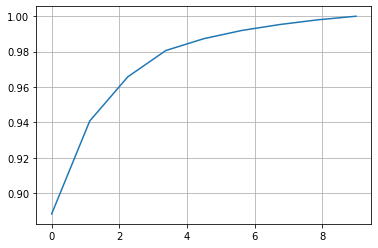

In [ ]:
plt.plot(np.linspace(0, train_PCA.shape[1], train_PCA.shape[1]), np.cumsum(pca.explained_variance_ratio_))
plt.grid()

In [ ]:
n_components = 5

pca_train = pd.DataFrame(train_PCA[:, :n_components])
pca_test = pd.DataFrame(test_PCA[:, :n_components])

pca_train = np.concatenate([static_train, pca_train, train.y.values.reshape(-1, 1)], axis=1)
pca_test = np.concatenate([static_test, pca_test, test.y.values.reshape(-1, 1)], axis=1)

clmns = ['galactic year', 'galaxy'] + [f'pc_{i}' for i in range(n_components)] + ['y']
pca_train = pd.DataFrame(pca_train, columns=clmns)
pca_test = pd.DataFrame(pca_test, columns=clmns)

In [ ]:
def find_previous_tgt(df, galaxy, current_year, trsh_year=5):

  df_ = df.dropna(axis=0)

  prev_year = df_[(df_['galaxy'] == galaxy)
                     & (df_['galactic year'] < current_year)]['galactic year'].max()

  if prev_year >= 0:
    prev_y = df_[(df_['galaxy'] == galaxy)
                     & (df_['galactic year'] == prev_year)].y.values[0]
    return  prev_year, prev_y 

  else:
    mean_y = df_[(df_['galaxy'] == galaxy)
                  & (df_['galactic year'] <= trsh_year)].y.mean()                   
    return np.nan, mean_y

In [ ]:
def create_lag_and_trend_features(train_df, test_df):

  '''
  Function adds `prev_y` and `trend` features in train and test datasets.
   `prev_y` - last known value of target before considering year.
   `trend` - difference between two last known values of target before the current year.
  '''

  df = pd.concat([train_df, test_df]).reset_index()

  last_y = []
  trend = []

  for idx in df.index:

    year = df.loc[idx, 'galactic year']
    galaxy = df.loc[idx, 'galaxy']

    prev_year_1, prev_y_1 = find_previous_tgt(df, galaxy, year)
    prev_year_2, prev_y_2 = find_previous_tgt(df, galaxy, prev_year_1)

    last_y.append(prev_y_1)
    trend.append(prev_y_2 - prev_y_1)

  df['prev_y'] = last_y
  df['trend'] = trend
  df.drop('index', axis=1, inplace=True)

  N = train_df.shape[0]
  train = df.loc[:N-1]
  test = df.loc[N:]

  return train, test

In [ ]:
train_lf, test_lf = create_lag_and_trend_features(train, test)

Then to generate KNN features first I calculate neighbours:

In [ ]:
train_and_test = pd.concat([train, test])

static_clmns = train_and_test.columns[:2]
clmns_to_scale = train_and_test.columns[2:-1]

static_part = train_and_test[static_clmns]
part_to_scale = train_and_test[clmns_to_scale]

In [ ]:
sclr = MinMaxScaler()
scaled_data = sclr.fit_transform(part_to_scale)
scaled_data = pd.DataFrame(scaled_data, columns=part_to_scale.columns)

df_scaled = np.concatenate([static_part, scaled_data], axis=1)
df_scaled = pd.DataFrame(df_scaled, columns=train_and_test.columns[:-1])
target = train_and_test.y

In [ ]:
knn_pools = find_knn_pool(df_scaled, max_knn=5)
red_pools = reduce_pools(knn_pools, max_knn=5, only_names=True)

In [ ]:
def create_knn_features(df, nn_dict, model, n_knn=[1, 3, 5]):

  '''
  Function predicts KNN feature for current galaxy and year based on the model, trained
  on KNN galaxies defined by `n_knn` for current year.
  '''

  knn_clmns = [f'{i}_knn' for i in n_knn]
  clmns = ['galaxy', 'galactic year'] + knn_clmns
  knn_features = pd.DataFrame(np.zeros(shape=[df.shape[0], len(clmns)]), columns=clmns)
  knn_features['galactic year'] = df['galactic year']
  knn_features['galaxy'] = df['galaxy']
  
  for idx in df.index:
    galaxy = df.loc[idx, 'galaxy']
    year = df.loc[idx, 'galactic year']
    for max_nn in n_knn:
      nn_galaxys = nn_dict[galaxy][:max_nn]
      data_for_model = df.query('galaxy in @nn_galaxys')[['galactic year', 'y']]
      data_for_model = data_for_model.dropna(axis=0)
      x = data_for_model['galactic year'].values.reshape(-1, 1)
      y = data_for_model.y
      model.fit(x, y)
      feature = model.predict(np.array(year).reshape(-1, 1)).clip(0)

      mask = (knn_features['galaxy'] == galaxy) & (knn_features['galactic year'] == year) 
      idx_to_fill = knn_features[mask].index
      knn_features.loc[idx_to_fill, f'{max_nn}_knn'] = feature

  return knn_features

In [ ]:
model = RandomForestRegressor()

df_scaled['y'] = target
knn_features = create_knn_features(df_scaled, red_pools, model, n_knn=[2, 3, 5])

In [ ]:
# Split KNN features on train and test
N = train.shape[0]
knn_features_train = knn_features.loc[:N-1]
knn_features_test = knn_features.loc[N:]

Then I merge preprocessed data and generated features in final datasets:

In [ ]:
train_extended = pd.merge(pca_train, knn_features_train, on=['galaxy', 'galactic year'], how='left')
test_extended = pd.merge(pca_test, knn_features_test, on=['galaxy', 'galactic year'], how='left')

In [ ]:
train_extended_ = pd.merge(train_extended, train_lf[['prev_y', 'trend', 'galaxy', 'galactic year']],
                           on=['galaxy', 'galactic year'], how='left')
test_extended_ = pd.merge(test_extended, test_lf[['prev_y', 'trend', 'galaxy', 'galactic year']],
                          on=['galaxy', 'galactic year'], how='left')

I also add `knn_std` feature in order to represent the scatter between predictions based on different numbers of nearest neighbours:

In [ ]:
train_extended_['knn_std'] = train_extended_[['2_knn', '3_knn', '5_knn']].std(axis=1)
test_extended_['knn_std'] = test_extended_[['2_knn', '3_knn', '5_knn']].std(axis=1)

In [ ]:
train_extended_.head()

,galactic year,galaxy,pc_0,pc_1,pc_2,pc_3,pc_4,y,2_knn,3_knn,5_knn,prev_y,trend,knn_std
0,0,Large Magellanic Cloud (LMC),5.01087,0.848993,-0.660306,0.0318556,0.139936,0.0525898,0.052165,0.052408,0.052206,0.051796,0.0,0.000130
1,0,Camelopardalis B,1.57985,0.0403377,-0.756181,-0.240623,-0.0434057,0.059868,0.063445,0.064796,0.063342,0.059725,0.0,0.000811
2,0,Virgo I,6.48305,1.3227,-0.22768,0.696193,-0.0891609,0.0504491,0.048834,0.049260,0.049777,0.049111,0.0,0.000472
3,0,UGC 8651 (DDO 181),4.47831,-0.0518543,3.21628,1.28322,2.97902,0.0493942,0.049256,0.049147,0.049321,0.048261,0.0,0.000088
4,0,Tucana Dwarf,-3.21637,2.96255,0.0211456,-0.569051,-0.103903,0.154247,0.182121,0.191018,0.187453,0.155708,0.0,0.004477


In [ ]:
test_extended_.head()

,galactic year,galaxy,pc_0,pc_1,pc_2,pc_3,pc_4,y,2_knn,3_knn,5_knn,prev_y,trend,knn_std
0,17,KK98 77,1.24227,-0.634903,0.168701,-0.640458,-0.0600722,NaN,0.046302,0.046978,0.046552,0.041937,0.001645,0.000342
1,17,Reticulum III,4.93428,0.0845773,0.88882,-0.350445,-0.246174,NaN,0.040322,0.039460,0.039467,0.038980,0.002595,0.000496
2,18,Reticulum III,4.42966,-0.00241603,0.913859,-0.317154,-0.374316,NaN,0.040228,0.039347,0.039184,0.038980,0.002595,0.000562
3,17,Segue 1,2.37723,-0.194623,0.607038,0.259643,0.0627553,NaN,0.049327,0.046925,0.046647,0.038750,0.002449,0.001473
4,23,Virgo I,3.64566,-0.178772,0.856057,-0.572592,-0.281514,NaN,0.026192,0.025149,0.025649,0.029937,-0.000101,0.000522


In [ ]:
train_extended_.to_csv('/Data/train_subset_extended_fgen.csv', index=False)
test_extended_.to_csv('/Data/test_subset_filled_fgen.csv', index=False)